# Lab 5: Land Surface Temperature using CORINE-based Emissivity

## 🎯 Objectives
In this exercise, you will:
- Select a cloud-free Landsat 8 images from 2013 and 2023 (or different if you're sure that you'll spot a difference in land cover)
- Calculate Brightness Temperature (TB) from Band 10.
- Load CORINE Land Cover data and assign emissivity values to each land cover class.
- Use the Planck-based formula to calculate Land Surface Temperature (LST).
- Visualize and interpret the results.

## Step 1: Define Area of Interest (AOI)
- Use coordinates around Reduta street in Kraków.
- Create a polygon or rectangle using `ee.Geometry.Polygon`.

In [3]:
# Define AOI here
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='ee-skoraremotesensing')
aoi = ee.Geometry.Rectangle([19.947306, 50.097058, 19.969359, 50.103414])



## Step 2: Load Landsat 8 imagery for the dates you've picked
- Filter for low cloud cover (< 20%)
- Select Band 10 and convert to TB using: `TB = ST_B10 * 0.00341802 + 149.0`

In [5]:
# Load image and calculate TB
image_2013 = (
    ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate('2013-08-01', '2013-08-30')
    .filterMetadata('CLOUD_COVER', 'less_than', 20)
    .first()
)

image_2024 = (
    ee.ImageCollection('LANDSAT/LC09/C02/T1_L2')
    .filterBounds(aoi)
    .filterDate('2024-08-01', '2024-08-30')
    .filterMetadata('CLOUD_COVER', 'less_than', 20)
    .first()
)

tb_image_2013 = image_2013.select('ST_B10').multiply(0.00341802).add(149.0).rename('TB_2013')
tb_image_2024 = image_2024.select('ST_B10').multiply(0.00341802).add(149.0).rename('TB_2024')

print(image_2013.getInfo())
print(image_2024.getInfo())


{'type': 'Image', 'bands': [{'id': 'SR_B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30, 5690715]}, {'id': 'SR_B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [7961, 8051], 'crs': 'EPSG:32634', 'crs_transform': [30, 0, 303885, 0, -30

## Step 3: Load CORINE Land Cover data
- Use dataset `COPERNICUS/CORINE/V20/100m/2018`
- Clip it to your AOI

In [6]:
corine_2018 = (
    ee.Image('COPERNICUS/CORINE/V20/100m/2018')
)

corine_2018 = corine_2018.clip(aoi)

## Step 4: Assign emissivity to CORINE classes
- Use a dictionary for classes
- Use `remap()` and optionally a default value

In [7]:
# Create emissivity image

emissivity_dict = {
    111: 0.92,  # Continuous urban fabric
    112: 0.92,  # Discontinuous urban fabric
    121: 0.91,  # Industrial or commercial units
    211: 0.96,  # Non-irrigated arable land
    311: 0.98,  # Forests
    412: 0.97,  # Peat bogs
    324: 0.96,  # Transitional woodland-shrub
    231: 0.97   # Pastures
}
key_emissivity = list(emissivity_dict.keys())
values_emissivity = list(emissivity_dict.values())

emissivity_image = corine_2018.remap(key_emissivity, values_emissivity)

## Step 5: Calculate LST using the formula:
$$
LST = \frac{T_B}{1 + \left( \frac{\lambda \cdot T_B}{c_2} \right) \cdot \ln(\varepsilon)}
$$
- λ = 10.8 µm
- c₂ = 14388 µm·K

In [8]:
# Calculate LST
lambda_ = 10.8
c2 = 14388

lst_image = tb_image_2013.expression(
    'TB / (1 + ((lambda * TB) / c2) * log(1.0 / emissivity))', {
        'TB': tb_image_2013,
        'emissivity': emissivity_image,
        'lambda': lambda_,
        'c2': c2
    }).rename('LST')

## Step 6: Visualize the LST result
- Use palette: `['blue', 'yellow', 'red']`
- Suggested range: `min=290`, `max=325`

In [9]:
# Visualize LST
Map = geemap.Map()
Map.centerObject(aoi, zoom=15)

vis_params = {
    'palette': ['blue', 'yellow', 'red'],
    'min': 290,
    'max': 325,
}

Map.addLayer(lst_image, vis_params, 'LST')
Map

Map(center=[50.100236451862415, 19.95833250000626], controls=(WidgetControl(options=['position', 'transparent_…

## Step 7: (Optional) Analyze statistics by land cover class

In [10]:
# Optionally compute zonal statistics
lst_with_class = lst_image.addBands(corine_2018.rename('class'))


stats = lst_with_class.reduceRegion(
    reducer=ee.Reducer.mean().group(
        groupField=1,
        groupName='class'
    ),
    geometry=aoi,
    scale=100,  # Match CORINE resolution
    maxPixels=1e13
)


grouped_stats = stats.get('groups')
grouped_stats = ee.List(grouped_stats)

def safe_format_dict(d):
    d = ee.Dictionary(d)
    land_class = ee.Number(d.get('class'))
    mean_val = ee.Algorithms.If(d.contains('mean'), ee.Number(d.get('mean')).format('%.2f'), 'N/A')
    return ee.String('Class: ').cat(land_class.format()).cat(', Mean LST: ').cat(mean_val)


formatted = grouped_stats.map(safe_format_dict)
print(formatted.getInfo())

['Class: 112, Mean LST: 306.86', 'Class: 121, Mean LST: 308.99', 'Class: 211, Mean LST: 312.93', 'Class: 243, Mean LST: N/A']


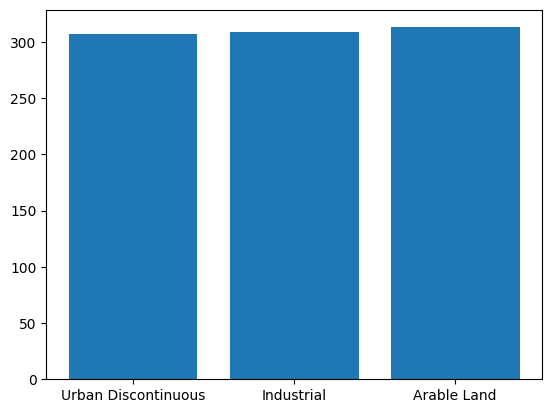

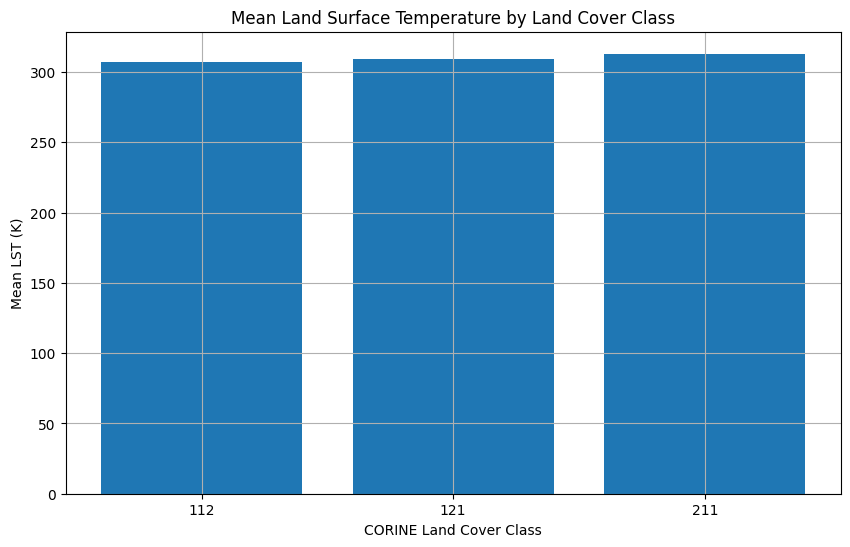

In [11]:
import pandas as pd
import matplotlib.pyplot as plt


grouped_list = grouped_stats.getInfo()


data = []
for item in grouped_list:
    class_id = item.get('class')
    mean_lst = item.get('mean')
    if mean_lst is not None:
        data.append({'Class': class_id, 'Mean_LST': mean_lst})

df = pd.DataFrame(data).sort_values(by='Mean_LST')

corine_labels = {
    111: 'Urban Continuous',
    112: 'Urban Discontinuous',
    121: 'Industrial',
    211: 'Arable Land',
    231: 'Pastures',
    311: 'Forests',
    324: 'Shrubland',
    412: 'Peat Bogs'
}

df['Label'] = df['Class'].map(corine_labels)
plt.bar(df['Label'], df['Mean_LST'])

plt.figure(figsize=(10, 6))
plt.bar(df['Class'].astype(str), df['Mean_LST'])
plt.xlabel('CORINE Land Cover Class')
plt.ylabel('Mean LST (K)')
plt.title('Mean Land Surface Temperature by Land Cover Class')
plt.grid(True)
plt.show()

## Step 8: (Optional - Easter Egg :)) Generate your own Land Cover Classification using TerraTorch and foundation models*

Based on the example/tutorial: https://aiforgood.itu.int/event/workshop-earth-observation-foundation-models-with-prithvi-eo-2-0-and-terratorch/

*to earn 5.0 grade that will make a great impact on your final grade

In [1]:
import ee
import requests
import rasterio
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import terratorch
from terratorch.models import EncoderDecoderFactory
from terratorch.datasets import HLSBands
import matplotlib.pyplot as plt

d:\miniconda\miniconda\envs\eo_lab_12\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
ee.Authenticate()
ee.Initialize(project='ee-skoraremotesensing')

In [20]:
# aoi = ee.Geometry.BBox(19.78, 50.01, 20.09, 50.13)  
aoi = ee.Geometry.Rectangle([19.94, 50.09, 19.98, 50.12])

s2_img = (ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
          .filterDate("2024-01-01", "2024-12-31")
          .filterBounds(aoi)
          .sort("CLOUD_COVER")
          .first()
          .select(['B2', 'B3', 'B4', 'B8']))  # Blue, Green, Red, NIR
download_url = s2_img.getDownloadURL({
    'scale': 10,
    'crs': 'EPSG:4326',
    'region': aoi,
    'format': 'GEO_TIFF'
})
print("Download URL:", download_url)


response = requests.get(download_url, stream=True)
with open("sentinel2_patch.tif", "wb") as f:
    for chunk in response.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

Download URL: https://earthengine.googleapis.com/v1/projects/1001488185526/thumbnails/40f8b7aad1d536c9965608214899462d-64fe5918bfc30a7ce61a984bb319e0b7:getPixels


In [21]:
# Load the image
with rasterio.open("sentinel2_patch.tif") as src:
    img = src.read([1, 2, 3, 4])  # Shape: (bands, height, width)

# Transpose to (height, width, bands)
img = np.transpose(img, (1, 2, 0))

# Normalize the image
img = img.astype(np.float32) / 10000.0
print("Image shape:", img.shape)

Image shape: (335, 446, 4)


In [5]:
tile_size = 256
h, w, c = img.shape
tiles = []

for i in range(0, h - tile_size + 1, tile_size):
    for j in range(0, w - tile_size + 1, tile_size):
        patch = img[i:i + tile_size, j:j + tile_size, :]
        if patch.shape == (tile_size, tile_size, c):
            tiles.append(patch)

tiles = np.stack(tiles)  # Now guaranteed to be (N, H, W, C)

In [6]:
tiles_tensor = torch.from_numpy(tiles).permute(0, 3, 1, 2)  # (N, C, H, W)

In [7]:
# Initialize the model factory
model_factory = EncoderDecoderFactory()

model = model_factory.build_model(
    task="segmentation",
    backbone="prithvi_eo_v2_300",  # Example backbone
    backbone_pretrained=True,
    backbone_bands=[
        HLSBands.BLUE,
        HLSBands.GREEN,
        HLSBands.RED,
        HLSBands.NIR_NARROW,
    ],
    necks=[{"name": "SelectIndices", "indices": [-1]},
           {"name": "ReshapeTokensToImage"}],
    decoder="FCNDecoder",
    decoder_channels=128,
    head_dropout=0.1,
    num_classes=4,  # Adjust based on your classification needs
)

INFO:root:Loaded weights for HLSBands.BLUE in position 0 of patch embed
INFO:root:Loaded weights for HLSBands.GREEN in position 1 of patch embed
INFO:root:Loaded weights for HLSBands.RED in position 2 of patch embed
INFO:root:Loaded weights for HLSBands.NIR_NARROW in position 3 of patch embed


In [8]:
model.eval()
with torch.no_grad():
    raw = model(tiles_tensor)    # ModelOutput
    logits = raw.output          # the tensor you want
    predictions = torch.argmax(logits, dim=1)  # shape: (N, H, W)

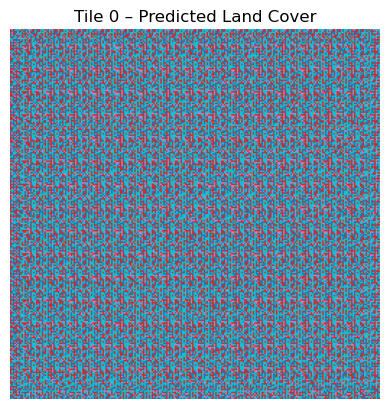

In [9]:
pred = predictions[0].cpu()  # (256, 256)
plt.imshow(pred, cmap='tab10')
plt.title("Tile 0 – Predicted Land Cover")
plt.axis('off')
plt.show()

In [10]:

# After loading and normalizing your image:
h, w, _ = img.shape      # height, width, bands
tile_size = 256

# Number of full tiles that fit along each axis:
tiles_per_col = h // tile_size
tiles_per_row = w // tile_size


label_map = predictions.cpu().numpy().reshape(tiles_per_col, tiles_per_row, 256, 256)

# Rearrange to full 2D array
rows = []
for r in range(tiles_per_col):
    rows.append(np.hstack(label_map[r]))
full_map = np.vstack(rows)  # shape: (tiles_per_col*256, tiles_per_row*256)


In [11]:

# Use the original image’s profile, updating count and dtype
profile.update({
    'count': 1,
    'dtype': rasterio.uint8,
    'height': full_map.shape[0],
    'width': full_map.shape[1],
    'transform': profile['transform']  # same georeferencing
})

with rasterio.open("classification_map.tif", 'w', **profile) as dst:
    dst.write(full_map.astype(rasterio.uint8), 1)

NameError: name 'profile' is not defined

In [15]:
import geemap
import ee

# (If not already) initialize Earth Engine
ee.Initialize()
m = geemap.Map(center=[50.10, 19.96], zoom=13)
m.add_basemap("HYBRID")

# Use the same palette you defined before
palette = ["red", "orange", "yellow", "green", "blue", "purple"]

m.add_raster(
    "classification_map.tif",
    layer_name="Land Cover Classification",
    palette=palette,
    opacity=0.7,
)

m


ImportError: localtileserver is not installed. Please install it before proceeding. https://github.com/banesullivan/localtileserver

In [14]:
%pip install rio-tiler

Note: you may need to restart the kernel to use updated packages.
